In [1]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [2]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import UQ_toolbox as uq

In [3]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)


In [4]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_592474/1194137215.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))


Ensemble AUC: 0.995, Ensemble Accuracy: 0.936


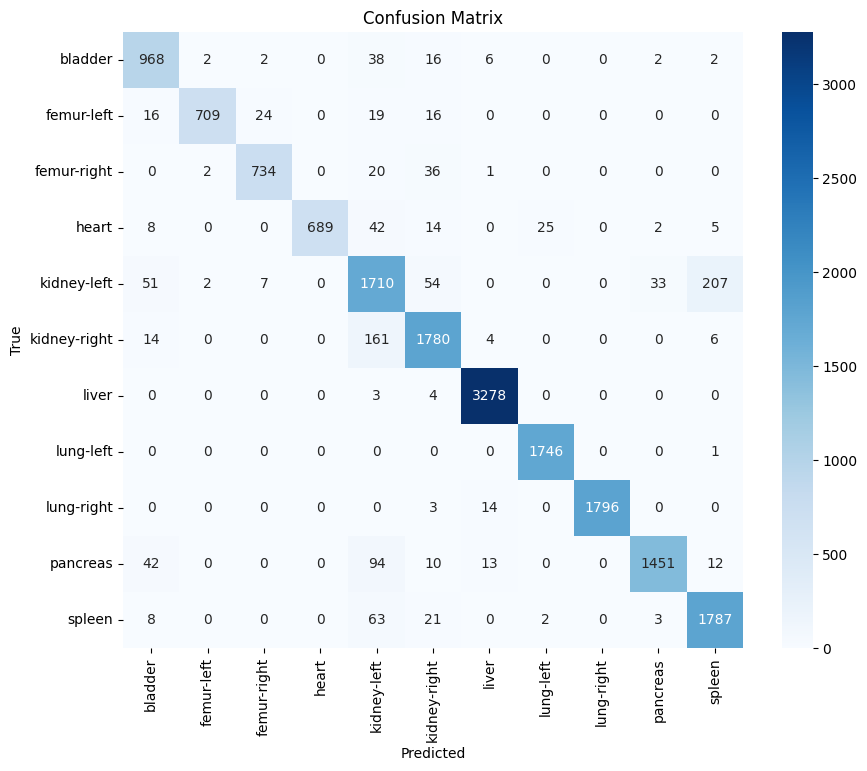

In [5]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Evaluate the ensemble model
evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_scores)
print(f'Ensemble AUC: {auc:.3f}, Ensemble Accuracy: {acc:.3f}')

# Generate the confusion matrix

cm = confusion_matrix(y_true, y_scores.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Set the random seed for reproducibility
torch.manual_seed(42)

# Calculate the sizes for training and calibration datasets
train_size = int(0.8 * len(combined_train_dataset))
calibration_size = len(combined_train_dataset) - train_size

# Split the combined_train_dataset into training and calibration datasets
train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

# Create DataLoaders for the new training and calibration datasets
calibration_loader = DataLoader(dataset=calibration_dataset, batch_size=128, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calibration_dataset)}')

Training dataset size: 32841
Calibration dataset size: 8211


/tmp/ipykernel_592474/3139380480.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
/tmp/ipykernel_592474/3139380480.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))


Calibration AUC: 1.000, Calibration Accuracy: 0.998, Calibration Balanced Accuracy: 0.997


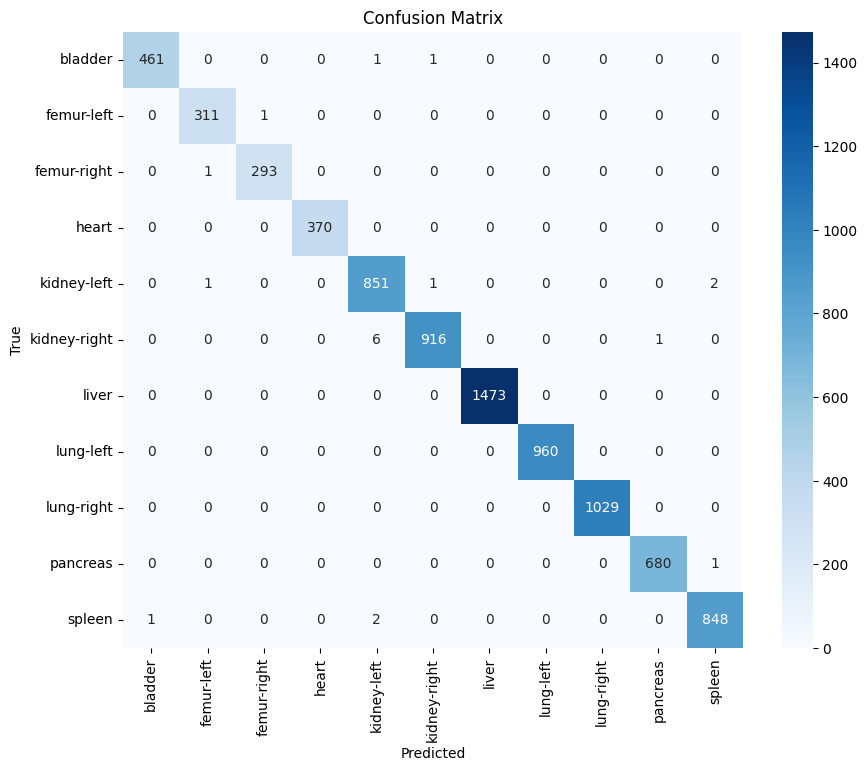

In [7]:
# Perform inference on the test set
y_true_calibration = []
y_scores_calibration = []
indiv_scores_calibration = [[], [], [], [], []]

with torch.no_grad():
    for data, target in calibration_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores_calibration, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true_calibration.extend(target.cpu().numpy().flatten())
        y_scores_calibration.extend(avg_output.cpu().numpy())

y_true_calibration = np.array(y_true_calibration)
y_scores_calibration = np.array(y_scores_calibration)
y_prob_calibration = np.array(F.softmax(torch.tensor(y_scores_calibration), dim=1))
# Compute AUC, Accuracy, and Balanced Accuracy for the calibration dataset

# Compute AUC
auc_calibration = roc_auc_score(y_true_calibration, y_prob_calibration, multi_class='ovr')

# Compute Accuracy
acc_calibration = accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

# Compute Balanced Accuracy
bacc_calibration = balanced_accuracy_score(y_true_calibration, y_prob_calibration.argmax(axis=1))

print(f'Calibration AUC: {auc_calibration:.3f}, Calibration Accuracy: {acc_calibration:.3f}, Calibration Balanced Accuracy: {bacc_calibration:.3f}')

# Generate the confusion matrix
cm = confusion_matrix(y_true_calibration, y_scores_calibration.argmax(axis=1))
# 
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [8]:
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))

/tmp/ipykernel_592474/2939530776.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [9]:
correct_predictions = [i for i in range(len(y_true)) if y_true[i] == np.argmax(y_scores[i])]
incorrect_predictions = [i for i in range(len(y_true)) if y_true[i] != np.argmax(y_scores[i])]

correct_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] == np.argmax(y_scores_calibration[i])]
incorrect_predictions_calibration = [i for i in range(len(y_true_calibration)) if y_true_calibration[i] != np.argmax(y_scores_calibration[i])]

In [ ]:
uq.apply_randaugment_and_store_results(calibration_loader, models, 2, 45, 50, device, folder_name=f'savedpolicies', batch_norm=True, image_size=28, nb_channels=3, softmax_application=True)

In [ ]:
best_aug = uq.perform_greedy_policy_search('savedpolicies', correct_predictions_calibration, incorrect_predictions_calibration, num_workers=90, max_iterations=30, num_searches=10, top_k=5, plot=True)
n, m, transformations = uq.extract_gps_augmentations_info(best_aug)

In [ ]:
transformations

In [10]:
test = ['[(14, np.float64(4.804355084196864)), (14, np.float64(0.49611068975454486))]',
 '[(0, np.float64(-40.8746015431739)), (14, np.float64(0.2894153094465963))]',
 '[(5, np.float64(-4.113784480387686)), (13, np.float64(16.440545374914386))]',
 '[(9, np.float64(24.877523566504152)), (11, np.float64(32.246219182437514))]',
 '[(5, np.float64(-6.845790299237748)), (9, np.float64(0.8910340184824648))]']

n=2
m=45

In [19]:
def display_tensor_image(tensor_image, title=None):
    """
    Display a tensor image using Matplotlib.

    Args:
        tensor_image (torch.Tensor): The image tensor to display. Expected shape is (C, H, W) or (H, W).
        title (str, optional): Title for the displayed image. Defaults to None.
    """
    if tensor_image.ndim == 3:
        # Convert the tensor to a numpy array and transpose the dimensions to (H, W, C)
        image = tensor_image.permute(1, 2, 0).cpu().numpy()
    elif tensor_image.ndim == 2:
        # Convert the tensor to a numpy array
        image = tensor_image.cpu().numpy()
    else:
        raise ValueError("Expected tensor with 2 or 3 dimensions, but got shape: {}".format(tensor_image.shape))

    plt.imshow(image, cmap='gray' if tensor_image.ndim == 2 else None)
    if title:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

In [18]:
with torch.no_grad():
    all_images = []
    for batch in test_loader:
        if isinstance(batch, dict):
            batch = (batch['image'], batch['label'])  # Convert to tuple

        images = batch[0]  # Access the images using positional indexing
        all_images.append(images)
    
    all_images = torch.cat(all_images, dim=0)  # Concatenate all batch images into one tensor
    aug_data, _  = uq.apply_augmentations(all_images, 5, True, n, m, True, 3, False, False, 28, test)

Manually set transform. Current transform: 
[(14,np.float64(4.804355084196864)),(14,np.float64(0.49611068975454486))]
Manually set transform. Current transform: 
[(0,np.float64(-40.8746015431739)),(14,np.float64(0.2894153094465963))]
Manually set transform. Current transform: 
[(5,np.float64(-4.113784480387686)),(13,np.float64(16.440545374914386))]
Manually set transform. Current transform: 
[(9,np.float64(24.877523566504152)),(11,np.float64(32.246219182437514))]
Manually set transform. Current transform: 
[(5,np.float64(-6.845790299237748)),(9,np.float64(0.8910340184824648))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


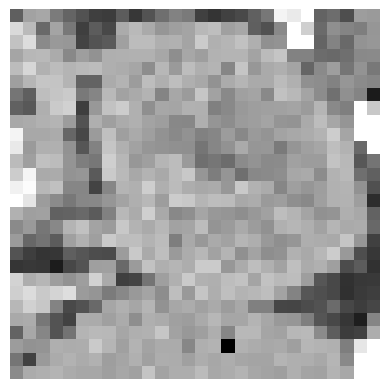

In [27]:
display_tensor_image(aug_data[1][0])

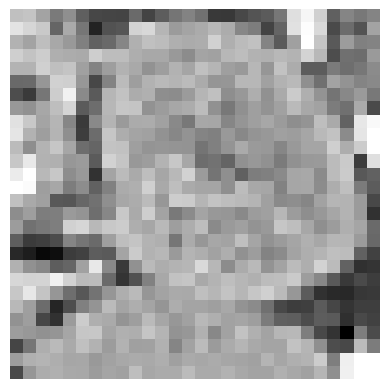

In [29]:
display_tensor_image(aug_data[2][0])

In [44]:
[torch.argmax(torch.mean(torch.stack([F.softmax(model(aug_data[i][0].unsqueeze(0).to(device)), dim=1) for model in models], dim=0), dim=0)) for i in range(5)]

[tensor(4, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(4, device='cuda:0')]

In [42]:
torch.mean(torch.stack([F.softmax(model(aug_data[2][0].unsqueeze(0).to(device)), dim=1) for model in models], dim=0), dim=0)

tensor([[9.1932e-04, 2.1976e-03, 4.2894e-04, 6.4835e-04, 7.3695e-01, 3.4744e-03,
         1.2933e-03, 5.4324e-04, 1.4100e-04, 2.2513e-01, 2.8274e-02]],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [11]:
stds_GPS_calibration, global_preds_GPS_calibration = uq.TTA(test, models, test_loader, device, usingBetterRandAugment=True, n=n, m=m, nb_channels=3, image_size=28, batch_norm=True, softmax_application=True)

Manually set transform. Current transform: 
[(14,np.float64(4.804355084196864)),(14,np.float64(0.49611068975454486))]
Manually set transform. Current transform: 
[(0,np.float64(-40.8746015431739)),(14,np.float64(0.2894153094465963))]
Manually set transform. Current transform: 
[(5,np.float64(-4.113784480387686)),(13,np.float64(16.440545374914386))]
Manually set transform. Current transform: 
[(9,np.float64(24.877523566504152)),(11,np.float64(32.246219182437514))]
Manually set transform. Current transform: 
[(5,np.float64(-6.845790299237748)),(9,np.float64(0.8910340184824648))]
Applying augmentation n : 0
Applying augmentation n : 1
Applying augmentation n : 2
Applying augmentation n : 3
Applying augmentation n : 4


In [14]:
stds_GPS_calibration

array([0.2611393 , 0.26115206, 0.26122424, 0.26139906, 0.26115024],
      dtype=float32)

In [13]:
fpr_std_gps, tpr_std_gps, auc_std_gps = uq.roc_curve_UQ_method_computation([stds_GPS_calibration[k] for k in correct_predictions], [stds_GPS_calibration[j] for j in incorrect_predictions])
uq.UQ_method_plot([stds_GPS_calibration[k] for k in correct_predictions], [stds_GPS_calibration[j] for j in incorrect_predictions], 'Stds', 'GPS', swarmplot=False)

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
auc_std_gps

In [ ]:
distances = uq.distance_to_hard_labels_computation(y_prob)

In [ ]:
uq.UQ_method_plot([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions], '1-max(prob)', 'Distance to hard labels', swarmplot=False)

In [ ]:
stds = uq.ensembling_stds_computation(indiv_scores)
uq.UQ_method_plot([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions], 'Stds', 'Standard deviations ensembling', swarmplot=False)

In [ ]:
fpr_distance_to_hard_labels, tpr_distance_to_hard_labels, auc_distance_to_hard_labels = uq.roc_curve_UQ_method_computation([distances[k] for k in correct_predictions], [distances[j] for j in incorrect_predictions])
fpr_stds, tpr_stds, auc_stds = uq.roc_curve_UQ_method_computation([stds[k] for k in correct_predictions], [stds[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling'], [fpr_distance_to_hard_labels, fpr_stds], [tpr_distance_to_hard_labels, tpr_stds], [auc_distance_to_hard_labels, auc_stds])

In [ ]:
mean_values = uq.standardize_and_mean_ensembling(np.column_stack((stds, distances)))

In [ ]:
uq.UQ_method_plot([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions], 'Mean(Zscore(stds, distances))', 'Standard deviations ensembling + distance to hard label', swarmplot=False)

In [ ]:
fpr_comb, tpr_comb, auc_comb = uq.roc_curve_UQ_method_computation([mean_values[k] for k in correct_predictions], [mean_values[j] for j in incorrect_predictions])
uq.roc_curve_UQ_methods_plot(['Distance prob to 1', 'Std ensembling', 'Combination'], [fpr_distance_to_hard_labels, fpr_stds, fpr_comb], [tpr_distance_to_hard_labels, tpr_stds, tpr_comb], [auc_distance_to_hard_labels, auc_stds, auc_comb])

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

# Define the metrics
metrics = {
    "Dist to HL": distances,
    "Std": stds
}

# Define the labels
labels = np.array([1 if i in correct_predictions else 0 for i in range(len(mean_values))])

# Function to compute metrics
def compute_metrics(uq_values, labels, threshold):
    predictions = (uq_values <= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    balanced_acc = balanced_accuracy_score(labels, predictions)
    return tn, fp, fn, tp, specificity, sensitivity, balanced_acc

# Function to find the optimal threshold
def find_optimal_threshold(uq_values, labels, max_fp_rate=0.001):
    thresholds = np.linspace(min(uq_values), max(uq_values), 1000)
    best_threshold = thresholds[0]
    best_tp = 0
    total_cases = len(labels)
    max_fp = total_cases * max_fp_rate
    for threshold in thresholds:
        tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
        if fp <= max_fp and tp > best_tp:
            best_tp = tp
            best_threshold = threshold
    return best_threshold

# Function to summarize results
def summarize_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    total_cases = len(labels)
    tp_proportion = tp / total_cases
    fp_proportion = fp / total_cases
    return tp, tp_proportion, fp, fp_proportion

def display_confusion_matrix_success_flags_prop(cm):
    # Convert cm to a Pandas DataFrame
    df_cm = pd.DataFrame(cm, index=['Failures', 'Success'], columns=['Failures', 'Success'])

    # Convert to proportions (normalize by total sum)
    cm_proportions = (cm.astype(np.float64) / cm.sum()) * 100  # Convert to percentage
    cm_proportions = pd.DataFrame(cm_proportions, index=df_cm.index, columns=df_cm.columns)  # Convert to DataFrame

    # Initialize annotations with the same shape as df_cm
    annotations = df_cm.copy().astype(str)

    # Add percentage values to the confusion matrix
    for i in range(df_cm.shape[0]):
        for j in range(df_cm.shape[1]):
            annotations.iloc[i, j] = f"{df_cm.iloc[i, j]} ({cm_proportions.iloc[i, j]:.1f}%)"

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=annotations, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
# Define a function to display the confusion matrix and metrics
def display_results(uq_values, labels, threshold):
    tn, fp, fn, tp, specificity, sensitivity, balanced_acc = compute_metrics(uq_values, labels, threshold)
    cm = confusion_matrix(labels, (uq_values <= threshold).astype(int))
    display_confusion_matrix_success_flags_prop(cm)
    print(f"Threshold: {threshold}")
    print(f"Specificity (TNR): {specificity:.2f}")
    print(f"Sensitivity (TPR): {sensitivity:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

# Create a DataFrame to store the results
results = []

# Perform ablation study for each metric separately
for metric_name, uq_values in metrics.items():
    best_threshold = find_optimal_threshold(uq_values, labels)
    tp, tp_proportion, fp, fp_proportion = summarize_results(uq_values, labels, best_threshold)
    results.append([metric_name, f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
    display_results(uq_values, labels, best_threshold)

# Perform ablation study for combinations of metrics
for r in range(2, len(metrics) + 1):
    for combination in itertools.combinations(metrics.keys(), r):
        combined_uq_values = uq.standardize_and_mean_ensembling(np.column_stack([metrics[key] for key in combination]))
        best_threshold = find_optimal_threshold(combined_uq_values, labels)
        tp, tp_proportion, fp, fp_proportion = summarize_results(combined_uq_values, labels, best_threshold)
        results.append([", ".join(combination), f"{tp} ({tp_proportion:.2%})", f"{fp} ({fp_proportion:.2%})"])
        display_results(combined_uq_values, labels, best_threshold)

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Metric(s)", "TP (Count, Proportion)", "FP (Count, Proportion)"])

# Display the results
print(results_df)